# Pentagons (single regular polygon)

We define some scripts to create the cutting patterns that show how
pentagons alone <u>cannot</u> tesselate the plane.<br>


### Strategy

- We define a basic shape using python library [Shapely](https://shapely.readthedocs.io/en/stable/manual.html).<br>
- We fill a portion of the plane with copies of this shape.
- We remove the polygons outside the frame which defines the shape of the riser
- We use the **Shapely** set operation "difference" to trip shapes too close to the edge (leaving some margin for welding the risers)


### Process Overview

<img src="./img/process_overview.png" width="80%">

In [258]:
# Imports
import math
from math import cos, sin, tan

from shapely.geometry import Polygon, box
from shapely import affinity, centroid, polygons, MultiPolygon

import svgwrite
from svgwrite import mm

import matplotlib.pyplot as plt
import numpy as np

In [259]:
import sys
sys.path.append('../..')  # Add the parent directory to Python path
from polygon_utils import (
    create_regular_polygon,
    plot_polygon_dict,
    plot_polygon_list,
    blue_plot,
    center_rectangle_on_polygons,
    is_polygon_inside_frame,
    save_polygon_list_to_svg
)

## FUNCTION DEFINITIONS

### Canvas and Polygon sizes

In [294]:
# DRAWING PARAMS:
drawing_height = 300
drawing_width = 1200
tabica_height = 192
tabica_width = 906

INSET_DISTANCE = 3.3   # X ratio gives gaps of about 2Xmm solid channels

band_width = 13 # solid margin, at top of step
side_inset = 6 # solid margin for sides of step

polygon_radius = 24 #24 

### Polygon creation

#### STAR 

In [261]:
# Create a 5-pointed star
from shapely.geometry import Polygon

def create_star_polygon(cx, cy, outer_radius, inner_radius):
    points = []
    for i in range(10):
        angle = math.pi * i / 5
        radius = outer_radius if i % 2 == 0 else inner_radius
        x = cx + radius * cos(angle)
        y = cy + radius * sin(angle)
        points.append((x, y))
    return Polygon(points)

alpha = math.pi/5
R = polygon_radius  # radius of the polygon
r1 = 2*R*sin(alpha/2) # small radius
r2 = 2*R*(cos(alpha)*(cos(alpha/2)*tan(alpha)+ sin(alpha/2))) # large radius
# Create star with outer radius matching polygon_radius and inner radius at 0.4 of outer
star = create_star_polygon(0, 0, r2, r1)
L = 2*R*sin(alpha) # side of the pentagon


### RHOMBUS

In [262]:
def create_thin_rhombus(center_x, center_y, side_length):
    """
    Create a thin rhombus for Penrose tiling.
    
    Parameters:
    - center_x, center_y: center coordinates of the rhombus
    - side_length: length of all sides (s in the description)
    - rotation_angle: rotation angle in radians (default 0)
    
    Returns:
    - Shapely Polygon object representing the thin rhombus
    
    The thin rhombus has:
    - Acute angles: alpha = π/5 (36°)
    - Obtuse angles: 4*alpha = 4π/5 (144°)
    """
    alpha = math.pi / 5
    
    # Base points for thin rhombus (acute angle at origin)
    # These points define a rhombus with acute angle alpha at (0,0)
    base_points = [
        (0, 0),  # P1
        (side_length, 0),  # P2
        (side_length + side_length * math.cos(alpha), side_length * math.sin(alpha)),  # P3
        (side_length * math.cos(alpha), side_length * math.sin(alpha))  # P4
    ]
    
    return Polygon(base_points)

## Parameters
<img src="./img/parameters.png" width="400px">

In [263]:
alpha = math.pi/5
R = polygon_radius  # radius of the polygon

a = R*cos(2*alpha)
b = R*sin(2*alpha)
c = R - a
h = R*cos(alpha)
l = R*sin(alpha)
L = 2*R*sin(alpha) # side of the pentagaon

r1 = 2*R*sin(alpha/2) # small radius
r2 = 2*R*(cos(alpha)*(cos(alpha/2)*tan(alpha)+ sin(alpha/2))) # large radius

x = 2*R*cos(alpha)*sin(alpha/2)
y = 2*R*sin(alpha)*sin(alpha/2)
z = 2*R*sin(alpha)*cos(alpha/2)


# Create star with outer radius matching polygon_radius and inner radius at 0.4 of outer
star = create_star_polygon(0, 0, r2, r1)
L = 2*R*sin(alpha) # side of the pentagon


In [264]:
# Create a pentagon (5 sides)
pentagon = create_regular_polygon(0,0, R, 5)


# Create rhombus
base_points = [
        (-L/2, -h),  # P1
        (+L/2, -h),  # P2
        (b+L/2, -h -c),  # P3
        (b-L/2, -h -c)  # P4
    ]
rhombus = Polygon(base_points)

R1 = Polygon([
    (b+L/2+2*b, -h-c),
    (4*b+L/2, -h),
    (b+2*L+2*y, -1*a-2*h),
    (L+2*b, -2*h-c-a)
])

R3 = Polygon([
    (4*b + L/2 + L, -h),
    (5*b + L/2 + L, -h -c),
    (6*b + L, -2*h -c-a),
    (5*b + L, -2*h -a),
])

R4 = Polygon([
    (2*b + 2*L + 2*y +b, a),
    (3*b + 2*L + 2*y +b, a+c),
    (3*b + 3*L + 2*y +b, a+c),
    (2*b + 3*L + 2*y +b, a),
])


In [265]:
# Create a Pentagon (5 sides)
pentagon = create_regular_polygon(0,0, R, 5)

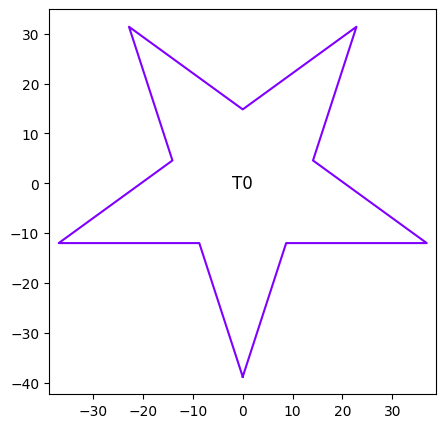

In [266]:
rotated_star = affinity.rotate(star, -90, origin="centroid")
polygon_dict = {}
polygon_dict['T0'] = rotated_star
plot_polygon_dict(polygon_dict)

### Dictionary of Polygons

We use a dictionary of polygons to plot them with a label. <br>
This is a temporary setup to visualize the transformations that define the position of the polygon.

In [267]:
down_star = affinity.rotate(star, -90, origin="centroid")
up_star = affinity.rotate(star, 90, origin="centroid")
down_polygon = affinity.rotate(pentagon, -90, origin="centroid")
up_polygon = affinity.rotate(pentagon, 90, origin="centroid")
left_rhombus = affinity.rotate(rhombus, 0, origin="centroid")
vertical_rhombus = affinity.rotate(rhombus, -2*36, origin="centroid")
# td1 = (L + R*sin(2*alpha) + r1*sin(alpha), R*cos(2*alpha) + L*sin(alpha/2)/tan(alpha))
s1 = (b + L + y, a + x)
s2 = (b, -(h+c+h+R+r1))
s3 = (2*b + 2*L + 2*y, -(h+c+h+R+r1 + a))
s4 = (4*b + 2*L + L/2 + 2*y  , 2*a+2*c+h+r1)


# polygon diagonal translations
# tuple encodes ("up"/"down", x, y)
pd = {1: ("d", b + L/2, a-h),
      2: ("d", b, a + R),
      3: ("u", b + L + y, -R-h),
      4: ("u", b, R + a + 2*h),
      5: ("d", b, -(c + 2*h)),
      6: ("d", b + L + y, R+a+h+a),
      7: ("d", b + L + y, -(3*h+a+c)),
      8: ("d", 3*b + L/2, a-h),
      9: ("d", b + 2*L + 2*y, a+R),
      10: ("u", 3*b + L, -(h+c+h+2*a)),
      11: ("u", b + 2*L + 2*y, R + a + 2*h),
      12: ("d", 2*b + 2*L + 2*y, -2*h),
      13: ("u", 2*b + 2*L + 2*y, 0),
      14: ("u", 5*b + L, -(h+c+h+2*a)),
      15: ("d", 3*b + 2*L + 2*y, a+R),
      16: ("u", 3*b + 2*L + 2*y, R + a + 2*h),
      17: ("d", 5*b + 2*L + y, -(3*h+a+c)),
      18: ("d", 5*b + L/2 + L, a-h),
      19: ("u", 4*b + 2*L + L/2 + 2*y, R + h),
      20: ("u", 5*b + 2*L + y, -R-h),
      }


polygon_dict = {}

polygon_dict['R0'] = affinity.translate(left_rhombus, 0,0)
polygon_dict['R1'] = R1
polygon_dict['R2'] = affinity.translate(vertical_rhombus, 4*b+L/2+y*math.cos(4*alpha/2),
                                        2*h+2*a+c+y*math.sin(4*alpha/2))
polygon_dict['R3'] = R3
polygon_dict['R4'] = R4

polygon_dict['T0'] = up_polygon

polygon_dict['S1'] = affinity.translate(down_star, s1[0], s1[1])
polygon_dict['S2'] = affinity.translate(down_star, s2[0], s2[1])
polygon_dict['S3'] = affinity.translate(up_star, s3[0], s3[1])
polygon_dict['S4'] = affinity.translate(up_star, s4[0], s4[1])

up_down_dict = {"d": down_polygon, "u": up_polygon}

for n in range(1,len(pd)+1):
    dict_index = f"P{n}"
    polygon_dict[dict_index] = affinity.translate(up_down_dict[pd[n][0]],pd[n][1],pd[n][2])
    
          


## Transformations
<img src="./img/translations.png" width="400px">

### Plotting Dictionaries of Shapes

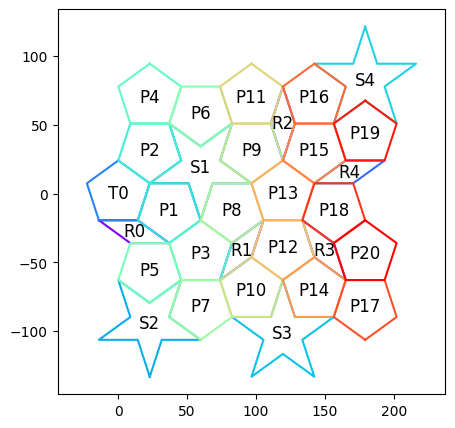

In [268]:
plot_polygon_dict(polygon_dict)

## List of Polygons

In order to generate the full list of polygons that fill the plane, we will store them in a list
instead of a dictionary.  <br>
This tile is somewhat different as the only holes will be stars and rhombuses.
The pentagons will only be etched.

We will thus create two different lists:
- pentagon_list
- cutting_list (stars and rhombuses)

In [269]:
cutting_list = []
pentagon_list = []
for key,poly in polygon_dict.items():
    if 'R' in key or 'S' in key:
        cutting_list.append(poly)
    else:
        pentagon_list.append(poly)


### Plotting Lists of Polygons

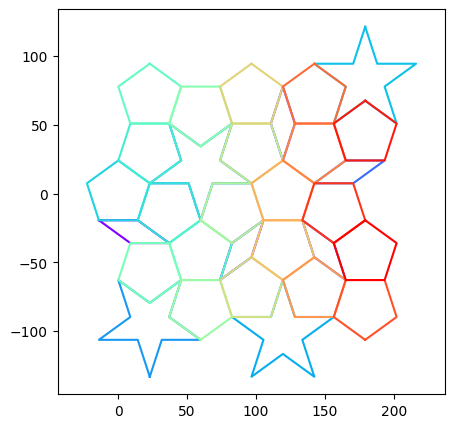

In [270]:
# initial_polygon_list = list(polygon_dict.values())
plot_polygon_list(cutting_list + pentagon_list)

### Translation Strategy

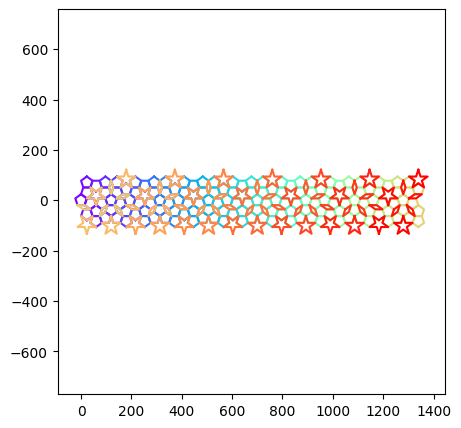

In [271]:
# let's make a copy of each polygon in the list
# translated by a vector (4b + 3L + 2y, 0)
# and plot the original list and the translated list together
full_pentagon_list = pentagon_list
for n in range(1,7):
    translated_copy = [affinity.translate(poly, n*(4*b + 3*L + 2*y), 0) for poly in pentagon_list]
    full_pentagon_list = full_pentagon_list + translated_copy

full_cutting_list = cutting_list
for n in range(1,7):
    translated_copy = [affinity.translate(poly, n*(4*b + 3*L + 2*y), 0) for poly in cutting_list]
    full_cutting_list = full_cutting_list + translated_copy

plot_polygon_list(full_pentagon_list + full_cutting_list)


# FRAME

The frame defines the rectangle that will become the cut sheet metal.
We want to delete polygons outside of this frame, and potentially "trim" some of the polygons at the edges,
to ensure the sheet metal can we welded robustly to the next piece.

In [272]:
frame = polygons([[0,0],
                  [0 + tabica_width, 0],
                  [0 + tabica_width, 0 + tabica_height],
                  [0, 0 + tabica_height]])

### Function to center frame around the polygons

In [273]:
# Center the rectangle
centered_frame = center_rectangle_on_polygons(full_cutting_list, frame)

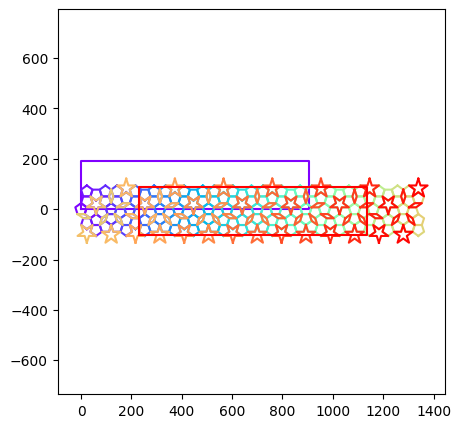

In [274]:
plot_polygon_list([frame] + full_pentagon_list + full_cutting_list+ [centered_frame])

### Delete polygons *mostly* outside of frame

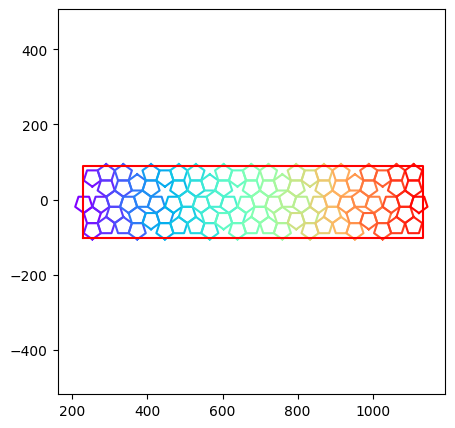

In [275]:
# Filter the full_polygon_list to keep only polygons "mostly" inside the rectangle
# by "mostly" we mean that the centroid of the polygon lies outside the frame.
filtered_pentagon_list = [polygon for polygon in full_pentagon_list if is_polygon_inside_frame(polygon, centered_frame)]
filtered_cutting_list = [polygon for polygon in full_cutting_list if is_polygon_inside_frame(polygon, centered_frame)]
# Update the full_polygon_list
full_pentagon_list = filtered_pentagon_list
full_cutting_list = filtered_cutting_list

# Plot the polygons
plot_polygon_list(full_pentagon_list + [centered_frame])

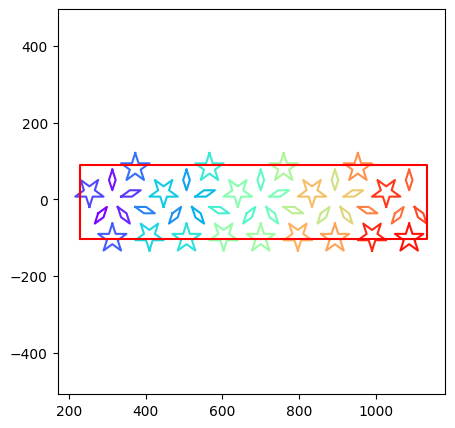

In [276]:
plot_polygon_list(full_cutting_list + [centered_frame])

## Perform Inset Operation on polygons
This shrinks each polygon to leave some material between them by a specified amount <br>
**We don't perform inset in this case as holes are sufficiently far appart**

In [277]:
# inset_polygon_list = []
# for poly in full_polygon_list:
#     inset_polygon_list.append(poly.buffer(-INSET_DISTANCE))



In [278]:
# plot_polygon_list(inset_polygon_list + [centered_frame])

## Creating a border with margin  

1. We define some bands around the frame

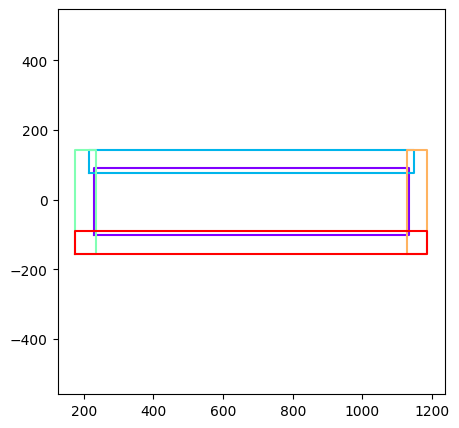

In [ ]:
margin = 40 # margin in mm
top_band = polygons([[centered_frame.bounds[0] - band_width, centered_frame.bounds[3] - band_width],
                    [centered_frame.bounds[0] - band_width, centered_frame.bounds[3] + band_width + margin],
                    [centered_frame.bounds[2] + band_width, centered_frame.bounds[3] + band_width + margin],
                    [centered_frame.bounds[2] + band_width, centered_frame.bounds[3] - band_width]])

left_band = polygons([[centered_frame.bounds[0] - band_width - margin, centered_frame.bounds[1] - band_width - margin],
                      [centered_frame.bounds[0] - band_width - margin, centered_frame.bounds[3] + band_width + margin],
                      [centered_frame.bounds[0] + band_width - side_inset, centered_frame.bounds[3] + band_width + margin],
                      [centered_frame.bounds[0] + band_width - side_inset, centered_frame.bounds[1] - band_width - margin]])

right_band = polygons([[centered_frame.bounds[2] - band_width + side_inset, centered_frame.bounds[1] - band_width - margin],
                      [centered_frame.bounds[2] - band_width + side_inset, centered_frame.bounds[3] + band_width + margin], 
                      [centered_frame.bounds[2] + band_width + margin, centered_frame.bounds[3] + band_width + margin],
                      [centered_frame.bounds[2] + band_width + margin, centered_frame.bounds[1] - band_width - margin]])

bottom_band = polygons([[centered_frame.bounds[0] - band_width - margin, centered_frame.bounds[1] - band_width - margin],
                        [centered_frame.bounds[0] - band_width - margin, centered_frame.bounds[1] + band_width],
                        [centered_frame.bounds[2] + band_width + margin, centered_frame.bounds[1] + band_width],
                        [centered_frame.bounds[2] + band_width + margin, centered_frame.bounds[1] - band_width - margin]])

plot_polygon_list([centered_frame, top_band, left_band, right_band, bottom_band])

In [280]:
def is_point_inside_rectangle(point, rect):
    """Check if a point is inside a rectangle."""
    x, y = point
    (rx1, ry1, rx2, ry2) = rect.bounds
    return rx1 <= x <= rx2 and ry1 <= y <= ry2

def is_polygon_inside_rectangle(polygon, rect):
    """Check if any vertices of a polygon are inside a rectangle."""
    return any(is_point_inside_rectangle(vertex, rect) for vertex in polygon.exterior.coords)

In [281]:
def create_bands(polygon_list):
    top_band_polygons = [polygon for polygon in polygon_list if is_polygon_inside_rectangle(polygon, top_band)]
    left_band_polygons = [polygon for polygon in polygon_list if is_polygon_inside_rectangle(polygon, left_band)]
    right_band_polygons = [polygon for polygon in polygon_list if is_polygon_inside_rectangle(polygon, right_band)]
    bottom_band_polygons = [polygon for polygon in polygon_list if is_polygon_inside_rectangle(polygon, bottom_band)]
    
    # deduplicate the list of polygons overlapped by each band:
    band_polygons = list(set(top_band_polygons + left_band_polygons + right_band_polygons + bottom_band_polygons))
    # keep the polygons outside of bands for later:
    all_other_polygons = [polygon for polygon in polygon_list if polygon not in band_polygons]
    
    return band_polygons, all_other_polygons

band_pentagons, inner_pentagons = create_bands(full_pentagon_list)
band_cutting, inner_cutting = create_bands(full_cutting_list)


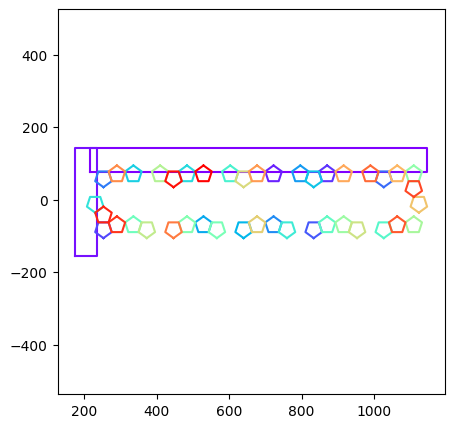

In [282]:
plot_polygon_list([top_band] + [left_band] + band_pentagons)

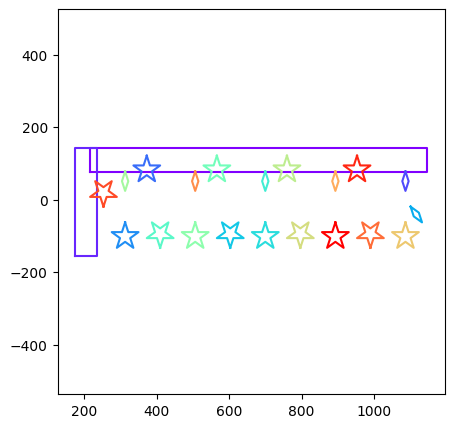

In [283]:
plot_polygon_list([top_band] + [left_band] + band_cutting)

In [284]:
def to_polygons(geom):
    if geom.is_empty:
        return None
    if geom.geom_type == 'Polygon':
        return geom
    if geom.geom_type == 'MultiPolygon':
        return [p for p in geom.geoms if not p.is_empty]
    # geometry collection: keep only polygonal parts
    if hasattr(geom, 'geoms'):
        return [p for p in geom.geoms if getattr(p, 'geom_type', '') == 'Polygon' and not p.is_empty]
    return []

def crop_polygons(polygon_list, band):
    """Crop a list of polygons to the band."""
    top_band, bottom_band, left_band, right_band = band
    cropped_polygons = []
    for poly in polygon_list:
        bit_to_keep_t = poly.difference(top_band)
        bit_to_keep_b = bit_to_keep_t.difference(bottom_band)
        bit_to_keep_l = bit_to_keep_b.difference(left_band)
        bit_to_keep = bit_to_keep_l.difference(right_band)
        cropped_polygons.append(bit_to_keep)
        if len(cropped_polygons) > 0:
            cropped_polygons = [to_polygons(poly) for poly in cropped_polygons]
            # flatten the list so there are only polygons, not lists of polygons
            flat_cropped_polygons = []
            for poly in cropped_polygons:
                if type(poly) == list:
                    flat_cropped_polygons.extend(poly)
                else:
                    flat_cropped_polygons.append(poly)
            cropped_polygons = flat_cropped_polygons
        
        # some polygons are cropped down to nothing (no coordinates), so we need to remove them
        cropped_polygons = [poly for poly in flat_cropped_polygons if poly.exterior] 
    
    return cropped_polygons

cropped_pentagons = crop_polygons(band_pentagons, [top_band, bottom_band, left_band, right_band])
cropped_cuttings = crop_polygons(band_cutting, [top_band, bottom_band, left_band, right_band])




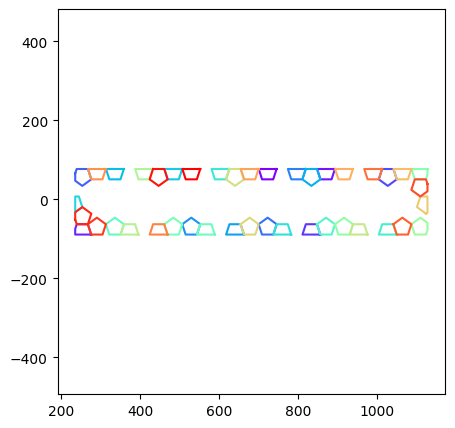

In [285]:
plot_polygon_list(cropped_pentagons)

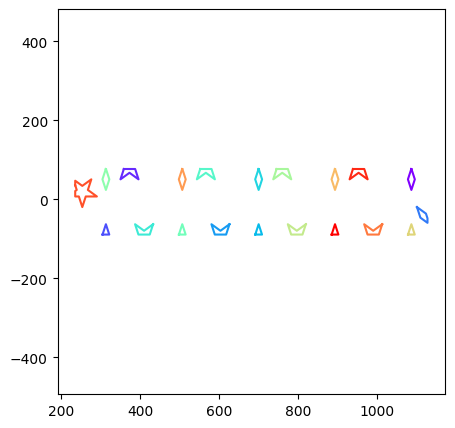

In [286]:
plot_polygon_list(cropped_cuttings)

In [287]:
final_pentagons =  inner_pentagons + cropped_pentagons + [centered_frame]
final_cuttings =  inner_cutting + cropped_cuttings + [centered_frame]


# SANITY CHECKS

- delete any polygon with an area less than a threshold

In [288]:
len(final_cuttings), len(final_pentagons)

(42, 99)

In [289]:
for poly in final_cuttings: 
    # pop polygon out of the list if area < 9
    if poly.area < 8:
        final_cuttings.remove(poly)

for poly in final_pentagons: 
    # pop polygon out of the list if area < 9
    if poly.area < 8:
        final_pentagons.remove(poly)
    

### Save POLYGONS to SVG

# SAVE


In [290]:
save_polygon_list_to_svg(final_cuttings, filename='tramo1.8_corte.svg')
save_polygon_list_to_svg(final_pentagons, filename='tramo1.8_grabado.svg')

In [291]:
save_polygon_list_to_svg(full_pentagon_list, filename='tramo1.8_draft.svg')

In [292]:
# Save as PNG
plt.figure(figsize=(12, 8))
for polygon in (final_cuttings + final_pentagons):
    x, y = polygon.exterior.xy
    plt.plot(x, y, color='blue', linewidth=0.5)
plt.axis('equal')
plt.savefig('tramo1.8.png', dpi=300, bbox_inches='tight')
plt.close()


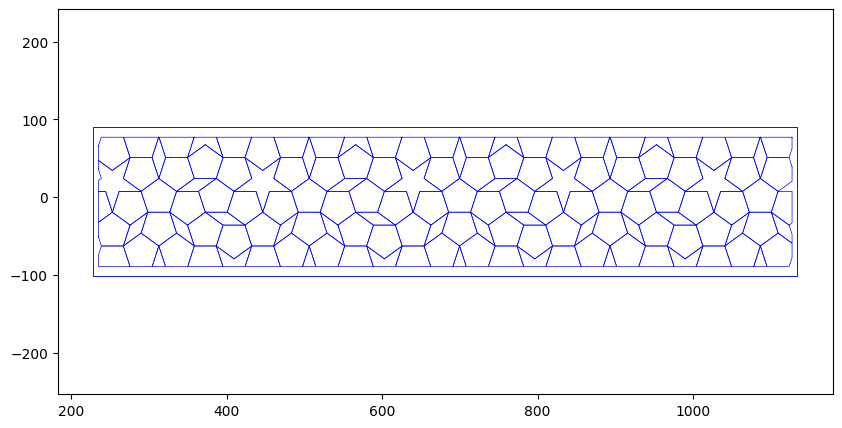

In [293]:
blue_plot(final_cuttings + final_pentagons)